# GAN Generative Adversarial Network - MNIS


生成對抗網路  
2014年，Ian Goodfellow在面對如何讓電腦自己產生圖片這一問題時  
所構思出來的方法: 讓兩個神經網路去對抗  

GAN的精神就是兩個神經網路  
一個扮演學生(Generator)，一個扮演老師(Discriminator)  
學生努力創作出結果，讓老師把結果與樣本比較後評價  
學生努力創作出更好的結果，老師也一步步的把標準變嚴格  
在經過無數次的來回交手以後，最後學生就能夠製造出與樣本同樣水準的作品  

GAN是近年來DL發展蓬勃的一支學問  
論文呈爆炸性的成長  
相關的結果有人統籌成一個GAN ZOO  
[GAN zoo](https://github.com/hindupuravinash/the-gan-zoo)

## MNIST手寫資料集訓練

利用MNIST資料  
來訓練一個簡單的GAN網路看看結果

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Reshape, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from keras.datasets import mnist

Using TensorFlow backend.


## 目標圖像
從MNIST中，只抽出training dataset來用就好  
GAN本質上是一種non supervise learning  
這裡必須把資料的數據散佈在原點為0範圍[-1,1]  
如果保持在[0,1]的話，訓練的結果不盡人意

In [2]:
(x, _), (_,_) = mnist.load_data()
x = (x.reshape(len(x),-1).astype('float32')-127.5)/127.5
shape= x.shape[1]

## Generator

學生的角色，負責輸入噪點，輸出圖像  
定義輸入維100維的噪點  
最後輸出28*28=784維的數據

In [3]:
Generator = Sequential()

Generator.add(Dense(256,input_dim=100,activation='relu'))
Generator.add(BatchNormalization(momentum=0.8))
Generator.add(Dense(512,activation='relu'))
Generator.add(BatchNormalization(momentum=0.8))
for _ in range(4):
    Generator.add(Dense(1024,activation='relu'))
    Generator.add(BatchNormalization(momentum=0.8))
    
Generator.add(Dense(shape, activation='tanh'))

Instructions for updating:
Colocations handled automatically by placer.


## Optimizer  
在操作經驗上來回看結果  
太大的學習率對於訓練的結果會壞掉，因此需要定義一下學習率

In [4]:
optimizer = Adam(lr=0.00015, beta_1=0.5, decay=8e-8)

## Discriminator
老師的角色  
負責輸入圖像  
判斷輸入的是好圖，或是壞圖  
由於是簡單的二分法，損失函數就利用binary_crossentropy

In [5]:
Discriminator = Sequential()

Discriminator.add(Dense(392,input_dim=784,activation='relu'))
Discriminator.add(Dense(196,activation='relu'))
Discriminator.add(Dense(1, activation='sigmoid'))
     
Discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

## GAN model

把genrator跟discriminator裝起來就成了GAN model  
對於這個GAN來說  
其目的是用來訓練generator  
所以在設定model時，需要把Discriminator的部分訓練參數給凍結

In [6]:
Discriminator.trainable = False
GAN = Sequential()
GAN.add(Generator)
GAN.add(Discriminator)

GAN.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

## Training

訓練的時候每個epoch丟入32筆資料，共訓練20000次  
訓練的順序依序是:  
1. 創造噪點，丟入generator產生合成圖像
2. 把合成圖像標記為0，樣本圖像標記為1，丟入Discriminator訓練之
3. 產生出新的噪點圖像並標記為1，丟入整體GAN model，這是為了讓generator能夠把參數修正到能產生出1的圖像
4. 重複以上訓練

Instructions for updating:
Use tf.cast instead.


C:\Users\a2720\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, [Discriminator: d_loss: 0.715431], [ Generator: loss: 0.653658]
epoch: 1000, [Discriminator: d_loss: 0.510434], [ Generator: loss: 1.049222]
epoch: 2000, [Discriminator: d_loss: 0.632676], [ Generator: loss: 0.699935]
epoch: 3000, [Discriminator: d_loss: 0.684077], [ Generator: loss: 0.723323]
epoch: 4000, [Discriminator: d_loss: 0.688286], [ Generator: loss: 0.785144]
epoch: 5000, [Discriminator: d_loss: 0.670624], [ Generator: loss: 0.984002]
epoch: 6000, [Discriminator: d_loss: 0.633307], [ Generator: loss: 0.637553]
epoch: 7000, [Discriminator: d_loss: 0.740039], [ Generator: loss: 0.689265]
epoch: 8000, [Discriminator: d_loss: 0.736670], [ Generator: loss: 0.662872]
epoch: 9000, [Discriminator: d_loss: 0.743440], [ Generator: loss: 0.653402]
epoch: 10000, [Discriminator: d_loss: 0.733814], [ Generator: loss: 0.694109]
epoch: 11000, [Discriminator: d_loss: 0.662722], [ Generator: loss: 0.784240]
epoch: 12000, [Discriminator: d_loss: 0.693808], [ Generator: loss: 0.726487]

C:\Users\a2720\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


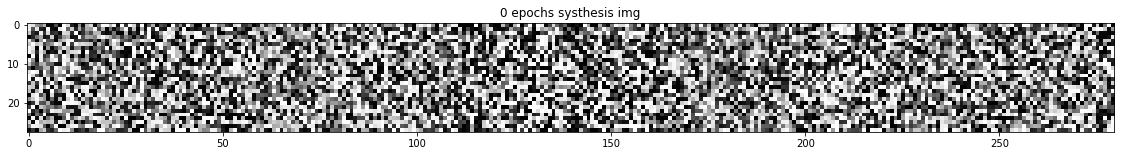

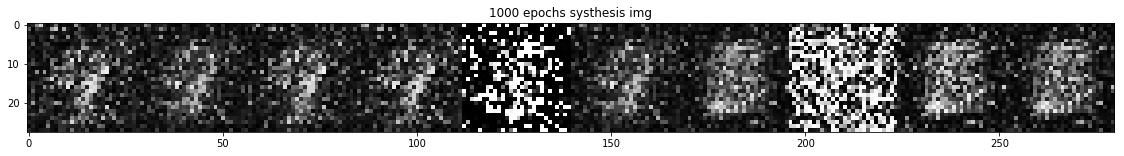

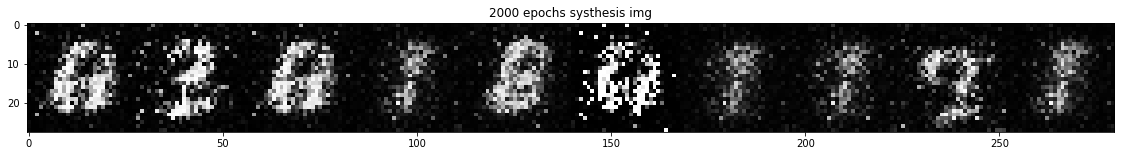

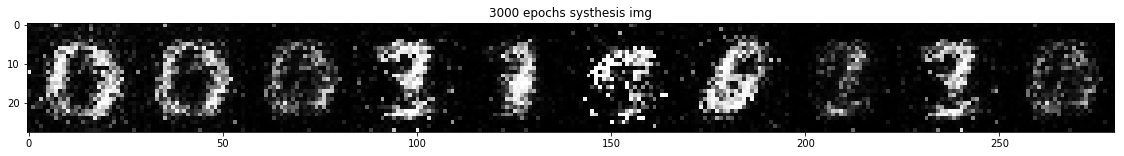

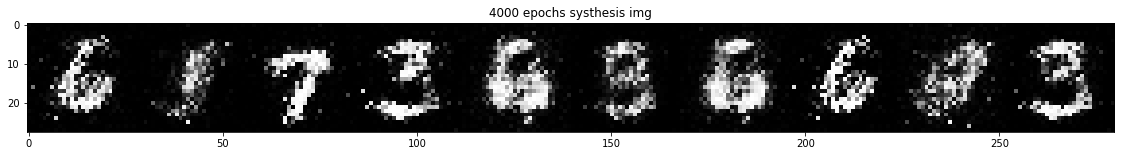

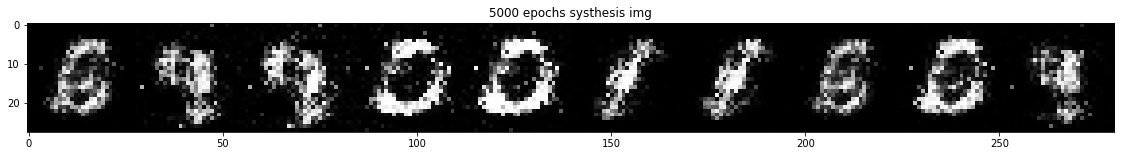

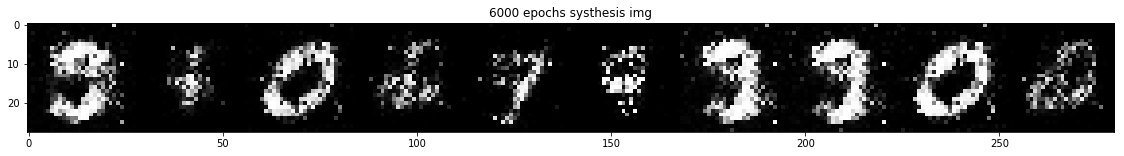

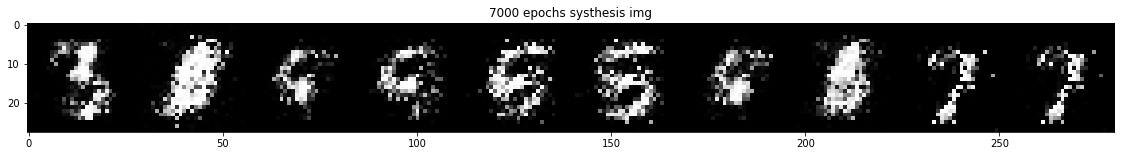

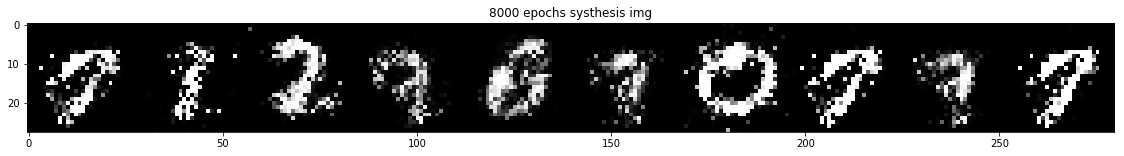

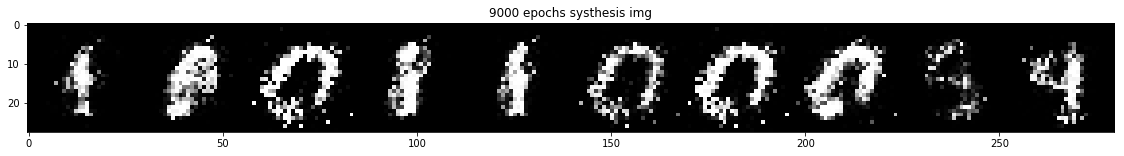

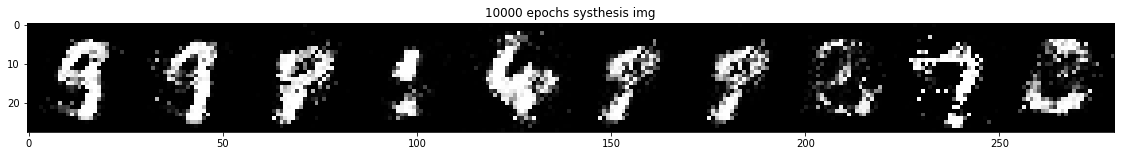

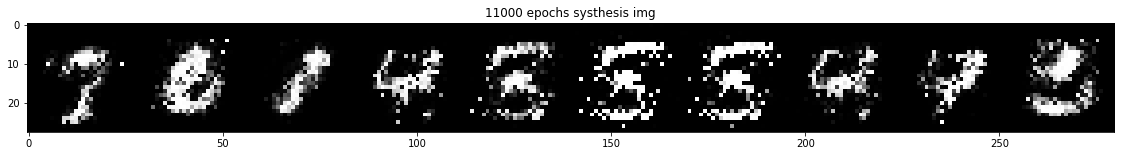

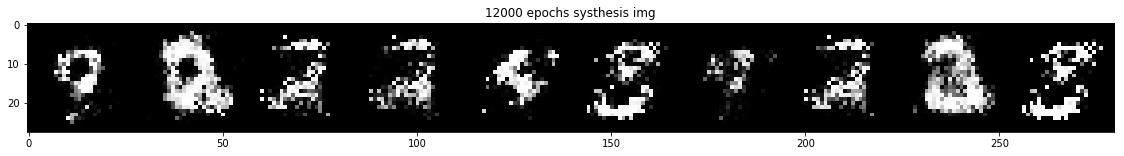

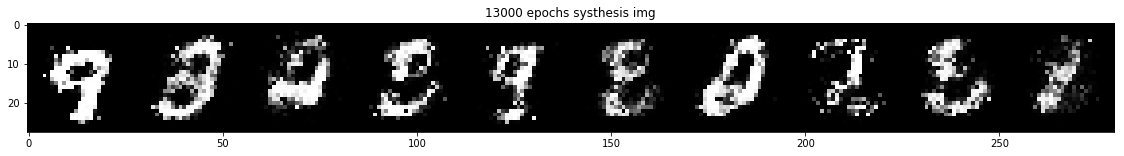

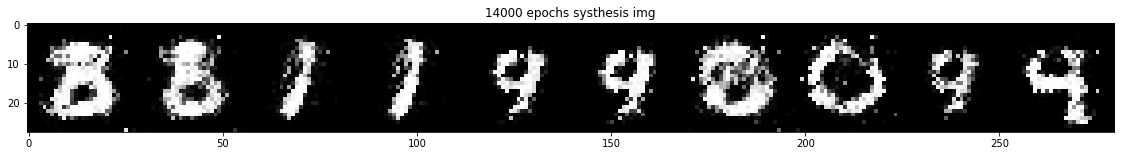

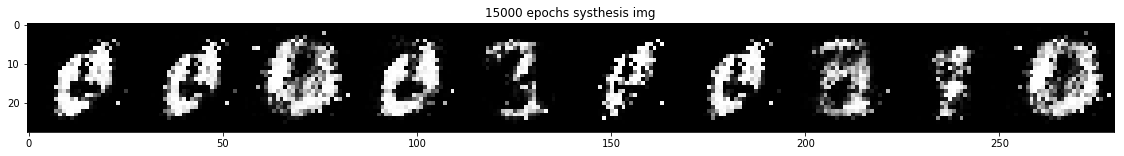

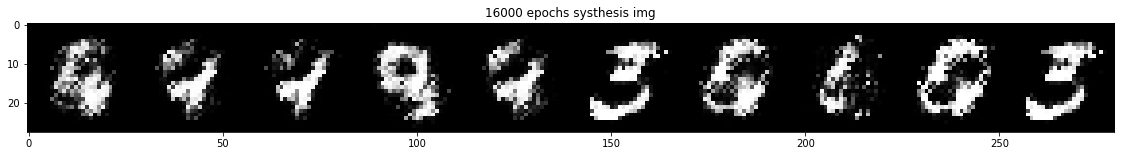

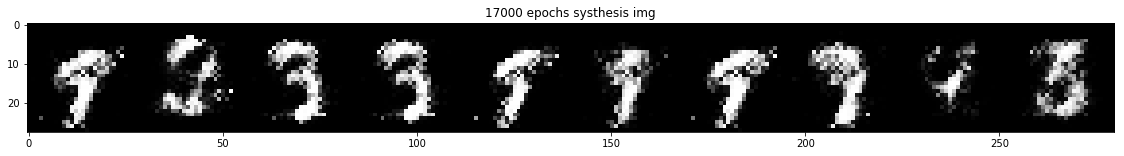

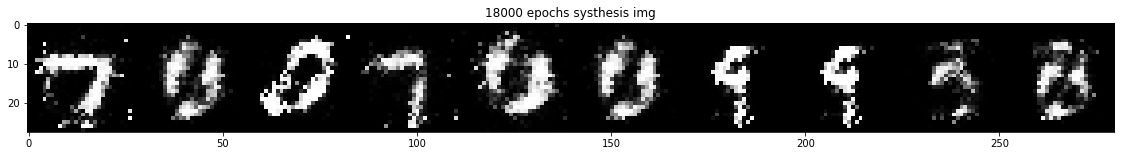

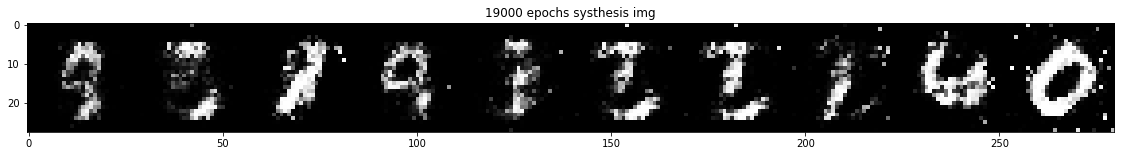

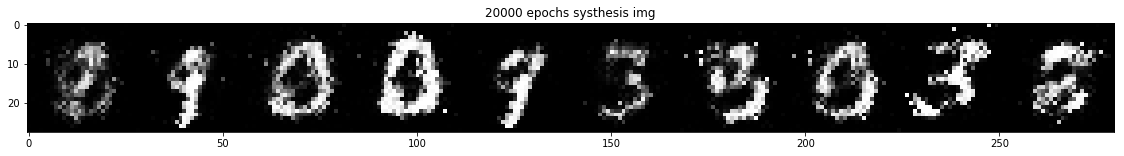

In [7]:
batch = 32
epochs = 20001

for times in range(epochs):
    # train discriminater
    noise = np.random.normal(0,1,(int(batch/2),100))
    synthesis_img = Generator.predict(noise)
    
    random = np.random.randint(0,60000-int(batch/2))
    sub_x = x[random:random+int(batch/2)]
    x_train_des = np.concatenate((sub_x,synthesis_img))
    y_train_des = np.concatenate((np.ones(len(sub_x)),np.zeros(len(synthesis_img))))
    d_loss = Discriminator.train_on_batch(x_train_des,y_train_des)
    
    #train generator
    noise = np.random.normal(0,1,(batch,100))
    noise_target = np.ones(len(noise))
    g_loss = GAN.train_on_batch(noise,noise_target)
    
    #option to see loss
    #print ('epoch: %d, [Discriminator: d_loss: %f], [ Generator: loss: %f]' % (times, d_loss[0], g_loss[0]))
    
    if times%1000 == 0:
        print ('epoch: %d, [Discriminator: d_loss: %f], [ Generator: loss: %f]' % (times, d_loss[0], g_loss[0]))
        img = np.ones((28,280))
        noise = np.random.normal(0,1,(10,100))
        synthesis_img = Generator.predict(noise)
        for i in range(10):
            img[:,i*28:(i+1)*28]=synthesis_img[i].reshape((28,28))
        plt.figure(figsize=(20,2)),plt.imshow(img,'gray')
        plt.title('%d epochs systhesis img'%times)

## Result
可以看到最後的結果  
generator能夠產生出越來越接近MNIST的結果  
周圍的雜質越來越少，數字的結構也越來越扎實

(<Figure size 1440x144 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1d608af32e8>)

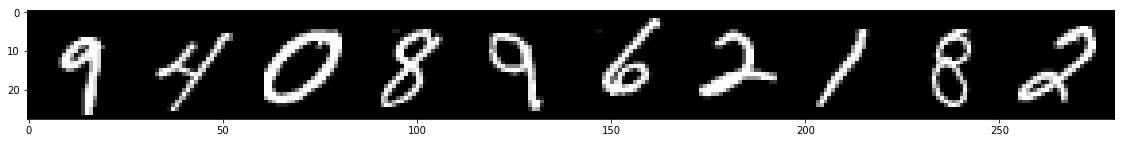

In [8]:
random = np.random.randint(0,60000-10)
sub_x = x[random:random+10]

img = np.ones((28,280))
for i in range(10):
    img[:,i*28:(i+1)*28]=sub_x[i].reshape((28,28))
plt.figure(figsize=(20,2)),plt.imshow(img,'gray')